In [1]:
import sys
import os, glob
os.getcwd()
from manager import Manager
import time, re
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
import scipy.optimize
import matplotlib.patches as mpatches
import os
from scipy.stats import moyal

In [ ]:
class AnaNA:
    def __init__(self):

        #########
        # At the beginning of your class __init__:
        self.saved_wfs = {}      # to store waveform per event
        self.saved_pulses = {}   # to store peaks/pulses per event
        self.trigger_position = None  # store trigger position
        ############

        
        self.m = Manager(midas=True, elec=False, tpc=True, toy=False, mc_gain=False, pdm_reco=True, is_mc=False, is_physics=False)
        self.m.info('vPDU MIDAS Data Reconstruction')

        # getting info from .ini files
        self.sampling         = self.m.config('daq', 'sampling', 'float')
        self.nevents          = self.m.config('base', 'nevents', 'float')
        self.baseline_to      = self.m.config('pdm_reco', 'baseline_to', 'float')
        self.downsample_by    = self.m.config('pdm_reco', 'downsample_by', 'int')
        self.reconstructed_as = self.m.config('pdm_reco', 'reconstructed_as', 'str')
        self.polarity         = self.m.config('pdm_reco', 'polarity', 'float')
        self.running_gate     = self.m.config('pdm_reco', 'running_gate', 'float')
        self.threshold_in_rms = self.m.config('pdm_reco', 'threshold_in_rms', 'int')
        self.min_time_between_peaks     = self.m.config('pdm_reco', 'min_time_between_peaks', 'float')
        self.extended_time_for_integral = self.m.config('pdm_reco', 'extended_time_for_integral', 'float')
        self.add_left_time_for_integral = self.m.config('pdm_reco', 'add_left_time_for_integral', 'float')
        self.trigger_pos                = self.m.config('pdm_reco', 'trigger_pos', 'float')
        self.roi_left                   = self.m.config('pdm_reco', 'roi_left', 'float')
        self.roi_right                  = self.m.config('pdm_reco', 'roi_right', 'float')
        self.channel_to_plot            = int(self.m.config('pdm_reco', 'channel_to_plot', 'int'))
        print(self.channel_to_plot)
        
        if self.downsample_by > 1 : self.sampling /= self.downsample_by

        # conversion from seconds to samples
        self.baseline_to                    = round(self.baseline_to * self.sampling)
        self.running_gate                   = round(self.running_gate * self.sampling)
        self.min_samples_between_peaks      = round(self.min_time_between_peaks * self.sampling)
        self.extended_samples_for_integral  = round(self.extended_time_for_integral * self.sampling)
        self.add_left_samples_for_integral  = round(self.add_left_time_for_integral * self.sampling)
        self.trigger_pos_samples            = round(self.trigger_pos * self.sampling)
        self.roi_left_samples               = round(self.roi_left * self.sampling)
        self.roi_right_samples              = round(self.roi_right * self.sampling)
        self.roi_tot_samples                = self.roi_right_samples - self.roi_left_samples

        self.timebin = 1e9 / self.sampling  # ns
        self.n_trig_events = self.m.config('roi', 'n_trigs', 'int')

        # getting the data type from the input file extension (case insensitive)
        input_path = self.m.config.input[0]
        file_extension = os.path.splitext(self.m.config.input[0])[1].lower()
        self.file_type = "unknown"
        
        #Added this section to allow the option of using directories in the files -i input for multiple files reconstruction
        if os.path.isdir(input_path):
          file_extension = os.path.splitext(glob.glob(f'{self.m.config.input}/*mid*')[0])[1].lower()
        else:
          file_extension = os.path.splitext(input_path)[1].lower()

        file_types = {
        ".root": "rootfile",
        ".lz4": "midas",
        ".mid": "midas",
        ".wfm": "wfm"
        }
        
        self.file_type = file_types.get(file_extension, "unknown")  # Default to "unknown" if not found
        print("Using", self.file_type, "data.")

    # returns the sample index of the max amplitude of first given number of events in the root file
    def get_trigger_position(self):
        is_first = True
        n = 0
        wf_list = []
        for i, wf in enumerate(self.events):
            if wf is None:
                continue
            if wf.nchannels == 0:
                continue
            if n > self.n_trig_events:
                break
            if is_first:
                wf_all = wf.adc_data
                print('First event:', wf.midas_event)
                is_first = False
            else:
                wf_list.append(wf.adc_data)
            n += 1

        if len(wf_list) == 0:
            raise ValueError("No waveforms found")

        wf_all = np.concatenate(wf_list, axis=0)
        if len(wf_all.shape) != 2:
            raise ValueError("Invalid dimensions for wf_all array")

        wf_all = wf_all
        trig_pos = int(np.argmax(np.mean(wf_all, axis=0),axis=0))
        self.m.info(f'trigger position: {trig_pos} samples')
        return trig_pos
    

    def plot_one_channel(self, wf, pulses, trigger_position , event_number):
        nsamp = wf.size
        t = np.arange(0., nsamp * self.timebin, self.timebin)
        line_1, = plt.plot(t,wf, color='darkorange', label='Baseline Subtracted Waveform')
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        plt.plot([xmin, xmax], [0, 0], ls='--', lw=2, color='darkgray', zorder=-10)
        ax.add_patch(mpatches.Rectangle(((trigger_position - self.roi_left_samples) * self.timebin, ymin),
                                         (self.roi_left_samples + self.roi_tot_samples) * self.timebin, ymax - ymin,
                                         fc='darkgray', alpha=0.3, color='darkgray', lw=2))
        plt.title("Waveform number " + str(event_number) + ", channel # " + str(self.channel_to_plot))
        plt.ylabel('Amplitude')
        plt.xlabel('Time [ns]')
        roi_patch = mpatches.Patch(alpha=0.3, color='darkgray', label='Region of interest')
        if pulses.size > 0:
            mark = plt.scatter(pulses[:, 0], pulses[:, 1], s=80, facecolors='none', edgecolors='r', label='hit')
            plt.legend(handles=[line_1, roi_patch, mark])
        else:
            plt.legend(handles=[line_1, roi_patch])
        fig = plt.gcf()
        fig.set_size_inches(11, 8)
        fig.tight_layout()
        # Save the figure to a file
        #import os; os.makedirs("waveforms", exist_ok=True)
        #plt.savefig(f"waveforms/wf_plot_{event_number}-ch{self.channel_to_plot}.png")
        #plt.savefig(os.path.join(output_dir, f"wf_plot_{event_number}-ch{self.channel_to_plot}.png"))
        # Close the figure
        # Additionally, save the waveform data to a text file
        #self.save_waveform_to_txt(wf, event_number)

    def expo(self, x, a, b):
        
        return (a * np.exp(-(x / b)))


    def fit_expo(self, x, y, p0 = None, y_errs = None, abs_errs = True):
        
        # This fit should always have some kind of default values, so if none are specified, generate them
        if p0 is None:
            p0 = (np.min(y), 16.0, np.min(y) / 100.0, 1500)
        
        try:
            coeffs, covariances = scipy.optimize.curve_fit(self.expo, x, y, p0 = p0, sigma = y_errs, absolute_sigma = abs_errs)
            
            return coeffs, np.sqrt(np.diag(covariances))
        
        except RuntimeError:
            print(f" fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!")
            
            return None

    def moyal_fit(self, x, loc, scale, A):
        return A * moyal.pdf(x, loc=loc, scale=scale)
  


    def fit_moyal(self, x, y, p0=None, y_errs=None, abs_errs=True):
        if p0 is None:
            loc_guess = x[np.argmax(y)]
            scale_guess = (max(x) - min(x)) / 10
            A_guess = np.max(y)
            p0 = (loc_guess, scale_guess, A_guess)
        try:
            coeffs, cov = scipy.optimize.curve_fit(
                self.moyal_fit,
                x,
                y,
                p0=p0,
                sigma=y_errs,
                absolute_sigma=abs_errs if y_errs is not None else False,
            )
        
            errors = np.sqrt(np.diag(cov))

            return coeffs, errors
            
        except RuntimeError:
            print("Error fitting Landau")
            return None
        




    

    def reco(self, channelsToAnalyse, RunDuration, fastArea, purityVal, plot):

        tau2_vals = []
        total_area = []
        fast_comp_area = []
        slow_comp_area = []

        ##########################################
        
        # channels_Sampled = 15
        # setTime = -1 # seconds, -1 for no time limit

        ##########################################
        
        
        t0 = time.time()
        t1 = t0
        self.m.info(f'{sys._getframe().f_code.co_name} started at {time.strftime("%H:%M on %d %B %Y", time.localtime(t0))}')
        # get the MIDAS object
        self.events = self.m.midas
        empty_event = 0
        tot_bytes = 0

        # calculate trigger position, aka "Auto-ROI"
        # NOTE: get_trigger_position() consumes the first "n_trig_events" events
        if self.trigger_pos>=0:
            trigger_position = self.trigger_pos_samples
            print(f"Trigger position set at {trigger_position} samples")
        if self.trigger_pos<0:
            print(f"Trigger position was not defined. Using the get_trigger_position() function.")
            trigger_position = self.get_trigger_position()
            
        start_roi = trigger_position - self.roi_left_samples

        # measure total run time
        run_duration = 0.0

        first_event = True
        # event loop - main loop
        peaks = []
        nonsense = 0

        

        
        for nev, event in enumerate(self.events):

            if event is None:
                empty_event += 1
                continue

            if event.nchannels == 0:
                empty_event += 1
                continue

            # End reconstruction if nevents have been reconstructed
            if self.nevents>0 and nev > self.nevents:
                break
            
            if nev % 1000 == 0 and nev > 0:  # progress print
                print(f'{nev:6d} events {time.time() - t1:1.3f}s / 1000 ev')
                t1 = time.time()

            # verbose information about midas event
            #event.info()

            nchan, nsamp = event.adc_data.shape
            tot_bytes += (nchan * nsamp * 2)
            if first_event:
                print("First event:", event.midas_event, " -->  Number of channels is", nchan, "- Number of samples is", nsamp)
                first_event = False

            # at this moment the saturation is just = 0 for all channels
            channel = np.arange(nchan, dtype=int)
            saturation = np.zeros(nchan, dtype=int)

            # calculate baseline
            bal = self.m.algos.get_baseline(event.adc_data, gate=self.baseline_to)
            rms = self.m.algos.get_rms(event.adc_data, gate=self.baseline_to)
            # subtract baseline, signals have negative polarity
            wfs = (event.adc_data - bal)

            # ROI integration using gate from config file
            roi = self.m.algos.get_roi(wfs, gate=self.roi_tot_samples, start=start_roi)
            roi = np.concatenate(roi)

            # WF analysis using the ARMA filter
            # [[time, amplitude, charge, channel],...]
            #peaks = self.m.tpc.get_hits(channel, wfs)

            # WF analysis using the running mean (optimal for ASIC readout)
            if self.reconstructed_as == 'asic' :
              run      = self.m.algos.running_mean(wfs, gate=self.running_gate)
              step     = np.where(run > self.threshold_in_rms*self.m.algos.get_rms(run, gate=self.baseline_to), 1, 0)
              segments = self.m.algos.get_segments(step, min_samples_to_merge=self.min_samples_between_peaks)



             
              # peaks is an array with 4 columns:
              # (0) time of the peak, (1) max height of the peak, (2) integral of the peak, (3) channel number of the peak
              peaks = np.zeros(shape=(len(segments),4))
              if segments.any() == False: # if 0 segments found fill peaks with -1s
                peaks[0,:] = [-1, -1, -1, 0]
              else:
                if self.file_type == 'rootfile' or self.file_type == 'wfm': segments = segments[:,1::]
                for i,s in enumerate(segments): # fill peaks with values for every segment found for given event
                  charge_left = 0
                  if self.file_type == 'rootfile' or self.file_type == 'wfm':
                    if (s[0] - self.add_left_samples_for_integral > 0): charge_left = s[0] - self.add_left_samples_for_integral
                    peaks[i,:] = [s[0], np.max(run[s[0]:s[1]]), np.sum(run[charge_left:s[1]+self.extended_samples_for_integral]), 0]
                  if self.file_type == 'midas':
                    if s is None: 
                        print(f'Nonsense segment in event {nev}, skipping...')
                        nonsense += 1
                        continue
                    else:               
                        charge_left = max(0, s[1] - self.add_left_samples_for_integral)
                        charge_right = min(len(run[s[0]]), s[2]+self.extended_samples_for_integral)
                        peaks[i,:] = [s[1], #Start position of peak
                                    np.max(run[s[0]][s[1]:s[2]]), #Peak max amplitude
                                    np.sum(run[s[0]][charge_left:charge_right]), #peak charge
                                    s[0]] #Channel index

            # trigger time stamp
            if event.trigger_time > run_duration:
                run_duration = event.trigger_time

            if self.file_type == 'midas':
                bl  = bal.flatten()
                rms = rms.flatten()

            # filling the output root file
            if (nev==0) :
                self.m.tree.fill_header( nchannels = len(channel) )
            self.m.tree.fill_event_header(nev)
            self.m.tree.fill_channels_pdu( channel, bl, rms, roi/self.sampling, saturation )
            if (len(peaks)>0 and peaks[0,0] > -1 ) :
                peaks[:,2] /= self.sampling # normalizes the charge integral with the time bin width
                self.m.tree.fill_peaks(peaks)
                #Eleason comment out for now
                #self.m.tree.fill_peaks_by_channel( peaks, channel)
            self.m.event.add_event()
                
            ################################
            if event.trigger_time/1e9 < RunDuration or RunDuration == -1:  # Check the event trigger time is less than set duration
                for i in range(channelsToAnalyse[0],channelsToAnalyse[1]):
            ################################
                    wf = run[1] # Waveform 
                    wfRun = run[1]

                    rmsMean = 2 * np.mean(rms) # Taking the mean of the baseline RMS 
                    first_pulse_idx = np.argmax(wf) # First pulse index is the index of the max amplitude value

                    if np.max(wf) > 50000: # Remove events that saturate the readout
                        pass
                    
                    t = np.arange(0., nsamp * self.timebin, self.timebin) # Time array

                    pulses = [] # Darkside own pulse finding algorithm
                    for p in peaks:
                        if p[3] == i:
                            pulses.append([p[0] * self.timebin, p[1]])
                    pulses = np.array(pulses)
                    
                    rmsMean = np.median(rms)
                    cross_idx = None

                    k = 4 # Sensitivity multiplier for finding the beginning of the pulse
                    threshold_array = k * rmsMean

                    pulse_indices = np.where(wf[10:400] > threshold_array)[0] # Finding the index of the point at which the pulse approx. starts

                    if len(pulse_indices) > 0:
                        cross_idx = pulse_indices[0]
                    else:
                        cross_idx = None
                    
                    preTrig = cross_idx
                    # twoNanoS = 80
                    # endTime = 1000

                    PulseEnd = None

                    if cross_idx != None:
                        for i in range(first_pulse_idx, nsamp, 1):
                            if wf[i] < 0:  # Pulse end is defined as the point at which the waveform crosses the baseline after main pulse
                                PulseEnd = i
                                break

                    
                    try:
                        
                        
                        ExpoFitVals = self.fit_expo(t[first_pulse_idx:PulseEnd], wf[first_pulse_idx:PulseEnd], p0 = (np.max(wf), 1800)) # Fitting an exponential to the data post first pulse index and before pulse end


                        if ExpoFitVals != None:
                            tau2_vals.append(ExpoFitVals[0][1]) # Append the decay constant to the tau2 array 

 

                        if PulseEnd != None and ExpoFitVals[0][1] > purityVal and ExpoFitVals[1][1] < 1: # If the pulse crosses the baseline AND the decay constant is greater than the set val AND the fit is reasonable


                            
                            fastIntegral = np.trapz(wf[preTrig:(preTrig+fastArea)],t[preTrig:(preTrig+fastArea)], dx = 8) # Trapezium rule to calulate the area of the fast component i.e. first X samples after rising edge starts. Each sample is 8ns
                                    
                            pulse_area = np.trapz(wf[preTrig:PulseEnd], t[preTrig:PulseEnd], dx = 8) # Total area from rising edge start to crossing the baseline
    
                            pulse_area_slow = np.trapz(wf[(preTrig+fastArea):PulseEnd], t[(preTrig+fastArea):PulseEnd], dx = 8) # Slow area is total area mius fast area

                    
                        if pulse_area > 0:
                            total_area.append(pulse_area)
                            fast_comp_area.append(fastIntegral)
                            slow_comp_area.append(pulse_area_slow)

                    except:
                        pass

                       
                    if plot == True: # If wanting to plot the events that pass criteria 
                        plt.figure(figsize=(11,8))
                        self.plot_one_channel(wf, pulses, trigger_position=trigger_position, event_number=nev)
                        self.plot_one_channel(wfRun, pulses, trigger_position=trigger_position, event_number=nev)
                        plt.show()
                        plt.close()
                            
                                                                             
                    
             
            else:
                break        
                    
        self.m.event.save()
        self.m.info(f'Run duration: {run_duration * 1e-9:1.2f}s')
        self.m.info(f'Events processed: {nev}')
        self.m.info(f'Processing {tot_bytes * 1e-6:1.3f}MB took {time.time() - t0:1.3f}s')
        self.m.info(f'Number of nonsense segments: {nonsense}\n')
        return tau2_vals, total_area, fast_comp_area, slow_comp_area

In [ ]:
# Config for running the script using existing code
sys.argv = [
    'vPDUreco',              
    '-i', '/bundle/data/DarkSide/phaidaq/run01905',
    '-c', 'vpdu.ini',        # config
    '-o', 'output.root'      # output
]


In [ ]:
if __name__ == '__main__':
    r = AnaNA()
    channelsToAnalyse = [2,3] # Channels to analyse 
    RunDuration = 60 # In seconds, -1 means no set limit
    fastArea = 80    # In number of sampls (f640 = 80)
    purityVal = 500  # In ns, events greater than this value are used 
    plot = False     # Plot events
    vals_gamma, total_area_vals_gamma, fast_comp_area_vals_gamma, slow_comp_area_vals_gamma = r.reco(channelsToAnalyse, RunDuration, fastArea, purityVal, plot)

Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log
Start Log

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]

[base]
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000
nevents 50000

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]

[daq]
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
data_format NAsetup2
n_channels 64
n_channels 64
n_channels 6

Reading config file: vpdu.ini
Updating configuration parameters.
Run number not set, using dummy value -1
Processing one directory /bundle/data/DarkSide/phaidaq/run01905 from the input
Reconstruction Algorithms: Activated
/bundle/data/DarkSide/phaidaq/run01905 is a directory
subrun 0: /bundle/data/DarkSide/phaidaq/run01905/run01905sub0000.mid
5
Using midas data.
Trigger position set at 500 samples
VX2740 no scope data
First event: 1  -->  Number of channels is 4 - Number of samples is 2000
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!


/tmp/ipykernel_1536765/3852697624.py:398: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fTwoHundred = np.trapz(wf[preTrig:(preTrig+fastArea)],t[preTrig:(preTrig+fastArea)], dx = 8)
/tmp/ipykernel_1536765/3852697624.py:401: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pulse_area = np.trapz(wf[preTrig:PulseEnd], t[preTrig:PulseEnd], dx = 8)
/tmp/ipykernel_1536765/3852697624.py:403: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pulse_area_slow = np.trapz(wf[(preTrig+fastArea):PulseEnd], t[(preTrig+fastArea):PulseEnd], dx = 8)
/tmp/ipykernel_1536765/3852697624.py:146: OptimizeWarning: Covariance of the parameters could not be estimated
  coeffs, covariances = scipy.optimize.curve_fit(self.expo, x, y, p0 = p0, sigma = 

 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!


/tmp/ipykernel_1536765/3852697624.py:136: RuntimeWarning: overflow encountered in multiply
  return (a * np.exp(-(x / b)))


 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
  1000 events 2.492s / 1000 ev
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_function_SciPy.fit_expo() - cannot fit exponential function to this event!
 fit_func

Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Run duration: 17.54s
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Events processed: 50001
Processing 799.936MB took 122.359s
Processing 799.936MB took 122.359s
Processing 799.936MB took 122.359s
Processing 799.936MB took 122.359s
Processing 799.936MB took 122.359s
Processing 799.936MB took 122.359s
Processing 799.936MB took

 50000 events 2.485s / 1000 ev
root file  output.root.root  written


In [102]:
print(len(total_area_vals_gamma),len(vals_gamma), len(fast_comp_area_vals_gamma), len(slow_comp_area_vals_gamma))

49839 49251 49839 49839


In [ ]:
# Fitting functions

def gaussian(x, A, mu, sigma):
    """
    Calculate y-axis data for a given set of Gaussian function parameters and x-axis data
    
    Args:
        x     : x-axis data
        A     : amplitude parameter
        mu    : mean parameter
        sigma : sigma parameter
    
    Returns:
        The calculated y-axis data
    """
    
    return A * np.exp(-(x - mu)**2 / (2.0 * sigma**2))


def fit_gaussian(x, y, p0 = None, y_errs = None, abs_errs = True):
    """
    Fit a Gaussian function to x-axis and y-axis data
    
    Args:
        x        : x-axis data
        y        : y-axis data
        p0       : (Optional) Tuple containing initial parameters of the form (A, mu, sigma)
        y_errs   : (Optional) Array of errors on the y-axis data
        abs_errs : (Optional) Flag for if the y_errs should be treated as absolute or relative values (i.e. if their absolute values should be used, or their sizes relative to each other)
    
    Returns:
        A tuple of the form: ((A, mu, sigma), (err_A, err_mu, err_sigma))
    """
    
    # This fit should always have some kind of default values, so if none are specified, generate them
    if p0 is None:
        p0 = (np.max(y), x[np.argmax(y)], 100.0)
    
    coeffs, covariances = scipy.optimize.curve_fit(gaussian, x, y, p0 = p0, sigma = y_errs, absolute_sigma = abs_errs)
    
    return coeffs, np.sqrt(np.diag(covariances))

151411.0
Biggest bin: 460.00 – 466.67 ns/ 2475 entries
Mean =  631.0897368672971


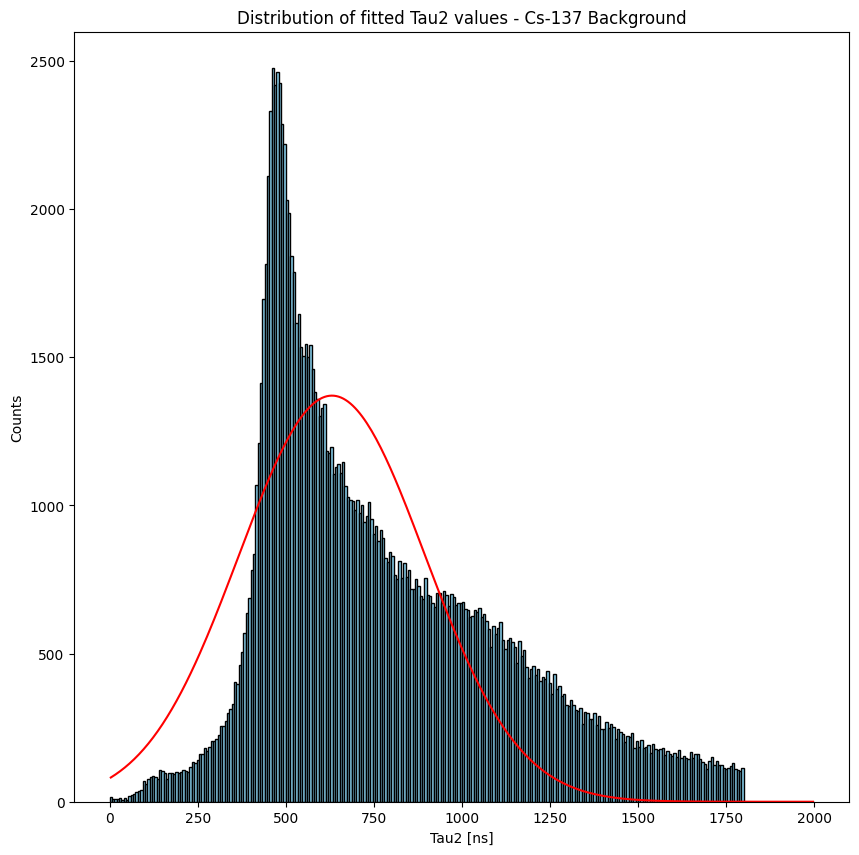

In [ ]:
# Purity plotting 

filtered_vals = [v for v in vals_gamma  if v < 1800 and v > 0]

totalBins = 300

counts, bin_edges, _ = plt.hist(filtered_vals, bins=totalBins, color="skyblue", edgecolor="black", range = (0,2000))
plt.close()

print(np.sum(counts))


max_bin_index = np.argmax(counts)
max_count = counts[max_bin_index]
bin_left = bin_edges[max_bin_index]
bin_right = bin_edges[max_bin_index + 1]
plotBinCent = (bin_edges[ : -1] + bin_edges[1 : ]) / 2

print(f"Biggest bin: {bin_left:.2f} – {bin_right:.2f} ns/ {int(max_count)} entries")




GaussVals = fit_gaussian(plotBinCent, counts)
print("Mean = " , GaussVals[0][1])
GaussArray = gaussian(plotBinCent, *GaussVals[0])
fig = plt.figure(figsize=(10,10))
plt.hist(filtered_vals, bins=totalBins, color="skyblue", edgecolor="black", range = (0,2000))
plt.plot(plotBinCent, GaussArray, color = 'red')
plt.xlabel("Tau2 [ns]")
plt.ylabel("Counts")
plt.title("Distribution of fitted Tau2 values - Cs-137 Background")
plt.show()

In [ ]:
# For loading the data from the CSV

import pandas as pd
df_loaded = pd.read_csv('./Data/Cs137_1tile1Multi_60sec600nsTau2f640.csv')


In [ ]:
# Changing to lists once loaded 

total_area_vals_Co60 = df_loaded['total_area_vals_Cs137'].tolist()
fast_comp_area_vals_Co60 = df_loaded['fast_comp_area_vals_Cs137'].tolist()
slow_comp_area_vals_Co60 = df_loaded['slow_comp_area_vals_Cs137'].tolist()

In [ ]:
filteredEventsToTArea = []
filteredEventsFraction = []
for i in range(0,len(total_area_vals_gamma)):
    fraction = fast_comp_area_vals_gamma[i]/fast_comp_area_vals_gamma[i]  # Calculate the prompt fraction i.e. fast area / total area
    # Additional filtering based on prompt fraction value and total area 
    if  fraction > 0.2 and fraction < 0.4: 
        if total_area_vals_gamma[i] > 0.01E8 and total_area_vals_gamma[i] < 0.7E8:
            filteredEventsToTArea.append(total_area_vals_gamma[i])
            filteredEventsFraction.append(fraction)

NameError: name 'total_area_vals_bck' is not defined

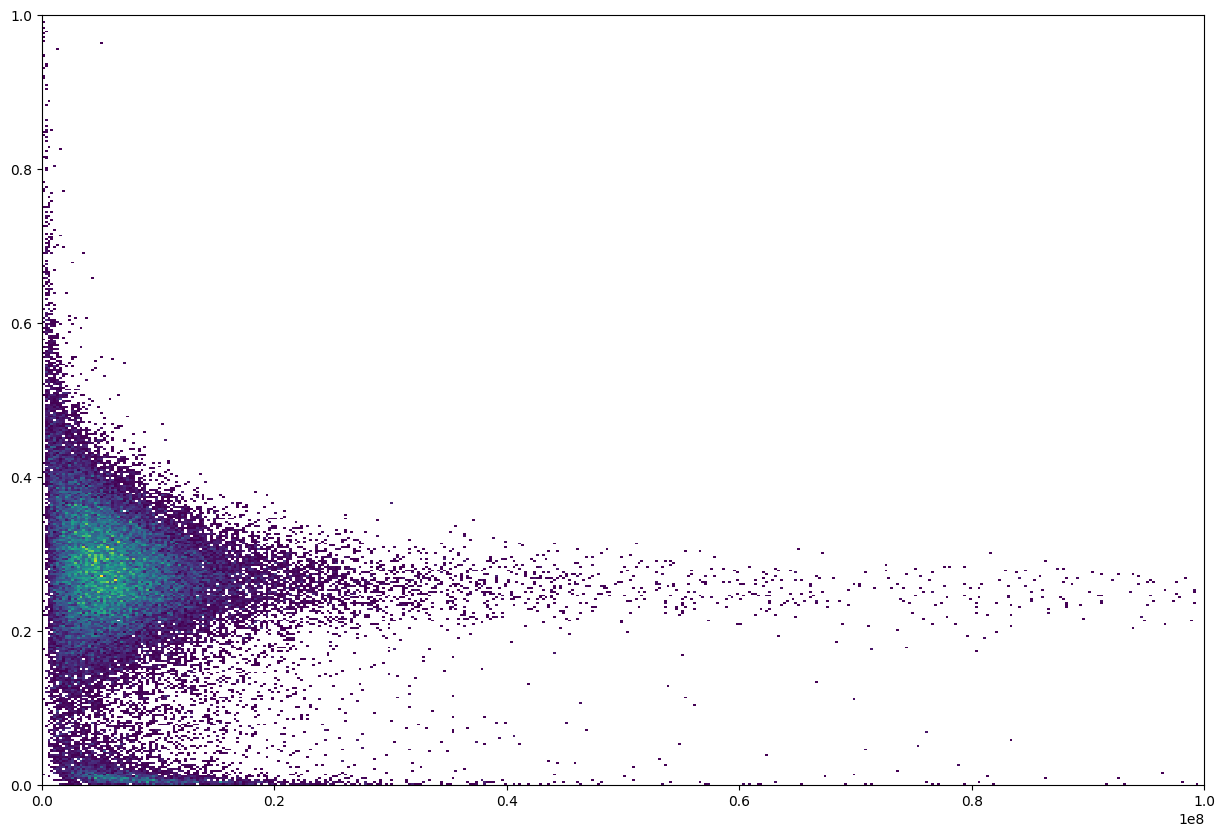

In [ ]:
fig=plt.figure(figsize=(15,10))
plt.hist2d(filteredEventsToTArea, filteredEventsFraction, bins = 400, cmin = 1, range = ([0,1e8],[0,1]))
plt.show()